# Import Packages and Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load Data

In [2]:
train_df = pd.read_csv('https://raw.githubusercontent.com/AksharJ47/regression-predict-api-template/master/utils/data/Train_Zindi.csv')
test_df = pd.read_csv('https://raw.githubusercontent.com/AksharJ47/regression-predict-api-template/master/utils/data/Test_Zindi.csv')
riders_df = pd.read_csv('https://raw.githubusercontent.com/AksharJ47/regression-predict-api-template/master/utils/data/Riders_Zindi.csv')

In [3]:
# Find datatypes and missing values
#Drop data not available in test, Pickup Time + label = Arrival times
train_df = train_df.drop(['Arrival at Destination - Day of Month',
                          'Arrival at Destination - Weekday (Mo = 1)',
                          'Arrival at Destination - Time'], axis=1)
test_df['Time from Pickup to Arrival'] = [np.nan]*test_df.shape[0]
full_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

merged_df = pd.merge(full_df, riders_df, how='left',
                          left_on='Rider Id',
                          right_on='Rider Id',
                          left_index=True)

In [4]:
# view dataset
merged_df.head(3)

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings
27,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,...,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745.0,1637,1309,13.8,549
739,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,...,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993.0,396,339,13.6,69
851,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,...,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455.0,1023,242,12.5,114


In [5]:
# Find datatypes and missing values
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28269 entries, 27 to 785
Data columns (total 30 columns):
Order No                                28269 non-null object
User Id                                 28269 non-null object
Vehicle Type                            28269 non-null object
Platform Type                           28269 non-null int64
Personal or Business                    28269 non-null object
Placement - Day of Month                28269 non-null int64
Placement - Weekday (Mo = 1)            28269 non-null int64
Placement - Time                        28269 non-null object
Confirmation - Day of Month             28269 non-null int64
Confirmation - Weekday (Mo = 1)         28269 non-null int64
Confirmation - Time                     28269 non-null object
Arrival at Pickup - Day of Month        28269 non-null int64
Arrival at Pickup - Weekday (Mo = 1)    28269 non-null int64
Arrival at Pickup - Time                28269 non-null object
Pickup - Day of Month          

# Data Cleaning and Formating

In [6]:
feature_names = {"Order No": "Order_No",
                 "User Id": "User_Id",
                 "Vehicle Type": "Vehicle_Type",
                 "Personal or Business": "Personal_Business",
                 "Placement - Day of Month": "Pla_Mon",
                 "Placement - Weekday (Mo = 1)": "Pla_Weekday",
                 "Placement - Time": "Pla_Time",
                 "Confirmation - Day of Month": "Con_Day_Mon",
                 "Confirmation - Weekday (Mo = 1)": "Con_Weekday",
                 "Confirmation - Time": "Con_Time",
                 "Arrival at Pickup - Day of Month": "Arr_Pic_Mon",
                 "Arrival at Pickup - Weekday (Mo = 1)": "Arr_Pic_Weekday",
                 "Arrival at Pickup - Time": "Arr_Pic_Time",
                 "Platform Type": "Platform_Type",
                 "Pickup - Day of Month": "Pickup_Mon",
                 "Pickup - Weekday (Mo = 1)": "Pickup_Weekday",
                 "Pickup - Time": "Pickup_Time",
                 "Distance (KM)": "Distance(km)",
                 "Precipitation in millimeters": "Precipitation(mm)",
                 "Pickup Lat": "Pickup_Lat",
                 "Pickup Long": "Pickup_Lon",
                 "Destination Lat": "Destination_Lat",
                 "Destination Long": "Destination_Lon",
                 "Rider Id": "Rider_Id",
                 "Time from Pickup to Arrival": "Time_Pic_Arr"}
renamed_df = merged_df.rename(columns=feature_names)
renamed_df.columns

Index(['Order_No', 'User_Id', 'Vehicle_Type', 'Platform_Type',
       'Personal_Business', 'Pla_Mon', 'Pla_Weekday', 'Pla_Time',
       'Con_Day_Mon', 'Con_Weekday', 'Con_Time', 'Arr_Pic_Mon',
       'Arr_Pic_Weekday', 'Arr_Pic_Time', 'Pickup_Mon', 'Pickup_Weekday',
       'Pickup_Time', 'Distance(km)', 'Temperature', 'Precipitation(mm)',
       'Pickup_Lat', 'Pickup_Lon', 'Destination_Lat', 'Destination_Lon',
       'Rider_Id', 'Time_Pic_Arr', 'No_Of_Orders', 'Age', 'Average_Rating',
       'No_of_Ratings'],
      dtype='object')

In [7]:
# Assume 0mm of rain where precipitation is missing
# Impute missing temperature with average
def Impute(input_df):
    '''Function fills missing values on the Temperature and
       Precipitation columns, all missing temperatures are
       imputed with the average temperature while all
       Precipitation columns are filled with 0mm of rain
    '''
    df = input_df.copy()
    cols_to_impute = ['Temperature',
                      'Precipitation(mm)']
    for col in cols_to_impute:
        if col == 'Temperature':
            a = round(df[col].mean(),1)
        if col == 'Precipitation(mm)':
            a = round(df[col].mean(),1)
        df[col] = df[col].fillna(a) 
    return (df)

In [8]:
imputed_df = Impute(renamed_df)

In [9]:
def time_change(input_df):
    '''Converts time format %H:%M:%S to seconds past midnight(00:00) of
       the same day rounded to the nearest second.
       ------------------------------
       12:00:00 PM --> 43200
       01:30:00 AM --> 5400
       02:35:30 PM --> 9330
     '''
    df = input_df.copy()
    from pandas.api.types import is_numeric_dtype
    def time_fn(row):
        b = row.split(' ')
        if b[1] == 'AM':
            c = 0
        else:
            c = 12
        b = b[0].split(':')
        b = [int(i) for i in b]
        if b[0] == 12:
            c -= 12
        # convertion to hours
        b[0] = (b[0] + c)*3600
        b[1] = (b[1])*60.0
        b[2] = (b[2])
        row = int(sum(b))
        return(row)
    time_columns = [
                'Pla_Time',\
                'Con_Time',\
                'Arr_Pic_Time',\
                'Pickup_Time',\
               ]
    for col in df.columns:
        if col in time_columns:
            if is_numeric_dtype(df[col]) is False:
                df[col] = df[col].apply(lambda x: time_fn(x))
            else:
                pass
    return(df)

In [10]:
time_changed_df = time_change(imputed_df) 

In [12]:
time_changed_df.head(3)

,Order_No,User_Id,Vehicle_Type,Platform_Type,Personal_Business,Pla_Mon,Pla_Weekday,Pla_Time,Con_Day_Mon,Con_Weekday,...,Pickup_Lat,Pickup_Lon,Destination_Lat,Destination_Lon,Rider_Id,Time_Pic_Arr,No_Of_Orders,Age,Average_Rating,No_of_Ratings
27,Order_No_4211,User_Id_633,Bike,3,Business,9,5,34546,9,5,...,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745.0,1637,1309,13.8,549
739,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,40576,12,5,...,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993.0,396,339,13.6,69
851,Order_No_1899,User_Id_265,Bike,3,Business,30,2,45565,30,2,...,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455.0,1023,242,12.5,114


# Model Feature Engineering

**New Columns added to dataset**
1. Rider Experience (Low,Medium,High):
   Age < 25th percentile --> Low Experience
   25th percentile < Age < 75th percentile --> medium experience
   Age > 75th percentile --> High experience
2. Temp_Band (Low,Medium,High)
   Temp. < 25th percentile --> Low T
   25th percentile < T < 75th percentile --> medium T
   T > 75th percentile --> High T
3. Conf_Pla_dif
   The time duration between placement and confirmation in seconds
4. Arr_Con_dif
   Time difference between arrival and confirmation time in seconds
5. Pic_Arr_dif
   Time difference between pickup and package arrival in seconds
6. Manhattand and harvesine distance between the pickup and
   destination points

In [13]:
# Add ride experience column
time_changed_df['Rider_Exp'] = pd.qcut(time_changed_df['Age'],
                                       q=[0, .25, .75, 1],
                                       labels=['low', 'medium', 'high'])

In [14]:
# Create Temperature band Column - 3 categories - low, mid, high
time_changed_df['Temp_Band'] = pd.qcut(time_changed_df['Temperature'],
                                       q=[0, .25, .75, 1],
                                       labels=['low', 'medium', 'high'])

In [15]:
def time_diffs(input_df):
    df = input_df.copy()
    df['Conf_Pla_dif'] = df['Con_Time'] - df['Pla_Time']
    df['Arr_Con_dif'] = df['Arr_Pic_Time'] - df['Con_Time']
    df['Pic_Arr_dif'] = df['Pickup_Time'] - df['Arr_Pic_Time']

    return df
time_changed_df = time_diffs(time_changed_df)

In [16]:
# Create manhattan dist
def manhattan(input_df):
    '''Calculates the manhattan distance between two location given
       the longitude and latitude of the locations
    '''
    df = input_df.copy()
    a = np.abs(df['Pickup_Lat'] - df['Destination_Lat'])
    b = np.abs(df['Pickup_Lon'] - df['Destination_Lon'])
    df['manhattan_dist'] = a + b
    return (df)

In [17]:
manhattan_df = manhattan(time_changed_df)

In [18]:
# days where placement date != delivery date
days_to_drop = manhattan_df[(manhattan_df['Pla_Mon']
                             != manhattan_df['Con_Day_Mon'])]

In [19]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h
def add_haversine(input_df):
    input_df_1 = input_df.copy()
    input_df_1['distance_haversine'] = haversine_array(input_df_1['Pickup_Lat'].values,
                                                       input_df_1['Pickup_Lon'].values,
                                                       input_df_1['Destination_Lat'].values,
                                                       input_df_1['Destination_Lon'].values)
    return input_df_1

In [20]:
harvestine_df = add_haversine(manhattan_df)
harvestine_df['distance_haversine']

27      1.930333
739    11.339849
851     1.880079
806     4.943458
159     3.724829
         ...    
611     3.631752
119    16.407578
134     5.398648
205    15.688753
785     7.294294
Name: distance_haversine, Length: 28269, dtype: float64

In [21]:
# Encode Rider Exp,Temp_Band and Personal/Business
def encode(input_df):
    df = input_df.copy()
    to_encode = ['Rider_Exp',
                 'Personal_Business',
                 'Temp_Band']
    df = pd.get_dummies(harvestine_df,columns = to_encode,drop_first = True)
    return(df)
data_encoded_df = encode(harvestine_df)

In [22]:
# Extract feature columns
numeric_cols = []
object_cols = []
time_cols = []
for k, v in data_encoded_df.dtypes.items():
    if (v != object):
        if (k != "Time_Pic_Arr"):
            numeric_cols.append(k)
    elif k.endswith("Time"):
        time_cols.append(k)
    else:
        object_cols.append(k)

In [34]:
# data_df = data_encoded_df[numeric_cols]
y = data_encoded_df[:len(train_df)]['Time_Pic_Arr']
X = data_encoded_df[numeric_cols][:len(train_df)]
test = data_encoded_df[numeric_cols][len(train_df):]

# Model Building and Evaluation 

In [24]:
# Split data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state = 42)

## Model Selection
The data was first validated using 6 Regression models to analyse which model potentially fits the data best, kfold cross validation was used with the data split into 10 different test and validation sets.

**Import and load models** 

In [25]:
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor,GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb

In [26]:
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.model_selection import KFold, GridSearchCV 
from sklearn.model_selection import cross_val_score, learning_curve
rs = 42
kfold = KFold(n_splits=10, random_state=rs, shuffle=True)

regressors = []
regressors.append(SVR())
regressors.append(GradientBoostingRegressor(random_state=rs))
regressors.append(ExtraTreesRegressor(n_estimators=rs))
regressors.append(RandomForestRegressor(random_state=rs))
regressors.append(xgb.XGBRegressor(random_state=rs, objective="reg:squarederror"))
regressors.append(lgb.LGBMRegressor(random_state=rs))

cv_results = []
rmse_scorer = make_scorer(mean_squared_error)
for regressor in regressors:     #scores to be minimised are negated (neg)
    cv_results.append(np.sqrt(cross_val_score(estimator = regressor,
                                              X = X_train,
                                              y = y_train,
                                              cv = kfold,
                                              scoring = rmse_scorer)))

cv_means = []
cv_stds = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_stds.append(cv_result.std())
    
cv_res = pd.DataFrame({ 
    "Algorithm": ["SVR", "GBR", "EXR", "RFR", "XGBR", "LGBM"],
    "CrossValMeans": cv_means, "CrossValErrors": cv_stds
                       })
cv_res = cv_res.sort_values("CrossValMeans", ascending=True)
print(cv_res)

C:\Users\Besodea\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Besodea\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Besodea\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Besodea\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: Fut

  Algorithm  CrossValMeans  CrossValErrors
5      LGBM     738.504286       34.392226
1       GBR     751.315204       34.930713
4      XGBR     764.823591       37.874634
2       EXR     769.803039       31.576560
3       RFR     796.915359       35.319130
0       SVR    1004.831483       31.714105


## Hyperparemeter tuning
From the above validation it can be seen that the following models produces the lowest errors:
1. LGBM
2. GBR
3. XGBR

In [27]:
params = {
    'n_estimators':[75], # [75, 95],
    'num_leaves': [15], #[12,15, 17],
    'reg_alpha': [0.02], #[0.02, 0.05],
    'min_data_in_leaf': [300],  #[250, 280, 300]
    'learning_rate': [0.1], #[0.05, 0.1, 0.25],
    'objective': ['regression'] #['regression', None]
    }

lsearch = GridSearchCV(estimator = lgb.LGBMRegressor(random_state=rs), cv=kfold,scoring=rmse_scorer, param_grid=params)
lgbm = lsearch.fit(X_train, y_train)

l_params = lgbm.best_params_
l_score = np.sqrt(abs(lgbm.best_score_))
print(lgbm.best_params_, np.sqrt(abs(lgbm.best_score_)))


{'learning_rate': 0.1, 'min_data_in_leaf': 300, 'n_estimators': 75, 'num_leaves': 15, 'objective': 'regression', 'reg_alpha': 0.02} 746.3297401201011


In [28]:
RFC = RandomForestRegressor(random_state=rs)
rf_param = {"max_depth":[None], "max_features":[3], "min_samples_split":[10],
           "min_samples_leaf": [3], "n_estimators":[300]}
rsearch = GridSearchCV(RFC, cv=kfold, scoring=rmse_scorer,param_grid=rf_param)
rfm = rsearch.fit(X_train, y_train)

r_score = np.sqrt(abs(rfm.best_score_))
r_params = rfm.best_params_
print(r_score, r_params)

759.0274038875427 {'max_depth': None, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 300}


In [29]:
def plot_learning_curve(estimator, title, X, y, ylim=None, n_jobs=-1, cv=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generating a plot of test and training learning curve"""
    plt.figure()
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("RMSE")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=rmse_scorer, shuffle=True)
    
    #scores - 5 runs, each with 10 fold
    train_scores_mean = np.mean(np.sqrt(train_scores), axis=1) #5 means (each size)
    train_scores_std = np.std(np.sqrt(train_scores), axis=1)
    test_scores_mean = np.mean(np.sqrt(test_scores), axis=1)
    test_scores_std = np.std(np.sqrt(test_scores), axis=1)
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r' )
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    
    plt.legend(loc='best')
    return plt

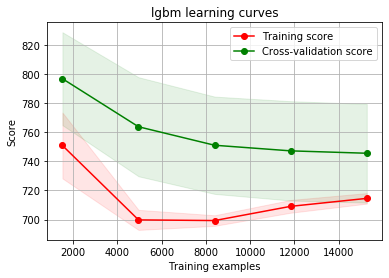

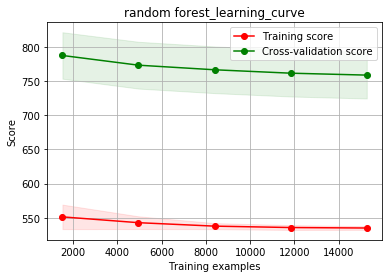

In [30]:
#Learning Curves
g = plot_learning_curve(lgbm.best_estimator_, "LGBM Learning Curves", X_train, y_train, cv=kfold)
g = plot_learning_curve(rfm.best_estimator_, "RFR Learning Curves", X_train, y_train, cv=kfold)
#lgbm: mse error comment here
#rf: mse error comment here

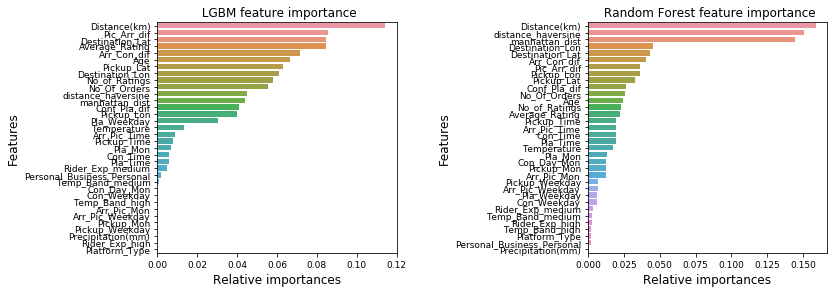

In [31]:
vals = lgbm.best_estimator_.feature_importances_
l_importance = np.array([ val/sum(vals) for val in vals ])
r_importance  = rfm.best_estimator_.feature_importances_
feats = X_train.columns

fig,axes = plt.subplots(1,2, figsize=(12, 8))
plt.subplots_adjust(top=0.6, bottom=0.2, hspace=.6, wspace=0.8)

indices = np.argsort(l_importance)[::-1]
g = sns.barplot(y=feats[indices], x=l_importance[indices], orient='h', ax=axes[0])
g.set_xlabel("Relative importances", fontsize=12)
g.set_ylabel("Features", fontsize=12)
g.tick_params(labelsize=9)
g.set_title(" LGBM feature importance")

index = np.argsort(r_importance)[::-1]
g = sns.barplot(y=feats[index], x=r_importance[index], orient='h', ax=axes[1])
g.set_xlabel("Relative importances", fontsize=12)
g.set_ylabel("Features", fontsize=12)
g.tick_params(labelsize=9)
g.set_title(" Random Forest feature importance")
plt.show()

## Model Building

In [32]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

lparams = {
           'learning_rate': 0.1, 'min_data_in_leaf': 300, 
           'n_estimators': 75, 'num_leaves': 20, 'random_state':rs,
           'objective': 'regression', 'reg_alpha': 0.02,
          'feature_fraction': 0.9, 'bagging_fraction':0.9}


lgbm = lgb.train(lparams, lgb_train, valid_sets=lgb_eval, num_boost_round=20, early_stopping_rounds=20)

lpred = lgbm.predict(X_test, num_iteration=lgbm.best_iteration)

print("The RMSE of prediction is ", mean_squared_error(y_test, lpred)**0.5)


C:\Users\Besodea\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 905031
Training until validation scores don't improve for 20 rounds
[2]	valid_0's l2: 850723
[3]	valid_0's l2: 806403
[4]	valid_0's l2: 770318
[5]	valid_0's l2: 740650
[6]	valid_0's l2: 716146
[7]	valid_0's l2: 695160
[8]	valid_0's l2: 678286
[9]	valid_0's l2: 663844
[10]	valid_0's l2: 652055
[11]	valid_0's l2: 642566
[12]	valid_0's l2: 634602
[13]	valid_0's l2: 628062
[14]	valid_0's l2: 622163
[15]	valid_0's l2: 617657
[16]	valid_0's l2: 612937
[17]	valid_0's l2: 609385
[18]	valid_0's l2: 606849
[19]	valid_0's l2: 604484
[20]	valid_0's l2: 601100
[21]	valid_0's l2: 598248
[22]	valid_0's l2: 596207
[23]	valid_0's l2: 594477
[24]	valid_0's l2: 592502
[25]	valid_0's l2: 591167
[26]	valid_0's l2: 589662
[27]	valid_0's l2: 588899
[28]	valid_0's l2: 587528
[29]	valid_0's l2: 585788
[30]	valid_0's l2: 584691
[31]	valid_0's l2: 583784
[32]	valid_0's l2: 582473
[33]	valid_0's l2: 581225
[34]	valid_0's l2: 580311
[35]	valid_0's l2: 579445
[36]	valid_0's l2: 578431
[37]	valid_0

# Data Insights

In [ ]:
plt.hist2d(x = time_changed_df['Pla_Mon'],y = time_changed_df['Pla_Time']/3600,
           bins=(10,20),
           range=((0,31),(0,24)))
plt.xlabel('Day_of_placement')
plt.ylabel('Hour_of_placement')
plt.title('service hours distribution')
plt.xticks(np.arange(0, 31, step=2))
plt.yticks(np.arange(0, 24, step=2))
plt.colorbar()
plt.show

In [ ]:
platform_types = time_changed_df['Platform_Type'].value_counts()
plt.bar(platform_types.index,platform_types)
plt.xlim(0, 5)
plt.title('Platform Type Frequency')
plt.xlabel('Platform_type')
plt.ylabel('Number of orders')
plt.xticks(np.arange(0, 5, step=1))
plt.show()

In [ ]:
sns.distplot(time_changed_df["Pla_Mon"], kde = False,bins = 4)
plt.ylabel('No. of orders')

Most Orders are placed on the first quarter of the month with most orders happening between hours of 10 AM and 12 PM(last graph and the 2D histogram convey this information), on an hourly basis most orders are recieved on the last 2 days of the month between 10 AM and 12 PM.
The majority of customers use Platform_type 3 for their packages.

In [ ]:
# Displays effect of experience on driver delivery time
time_changed_df['Rider_Exp']
time_changed_df['Time_Pic_Arr']/time_changed_df['Distance(km)']
plt.scatter(time_changed_df['Rider_Exp'],time_changed_df['Time_Pic_Arr']/time_changed_df['Distance(km)'])
plt.xticks(np.arange(0, 3, step=1))

# Zindi Submission File

In [35]:
lgbm_y = lgbm.predict(test, num_iteration=lgbm.best_iteration)
lgbm_output = pd.DataFrame({"Order No":test_df['Order No'], 
                           "Time from Pickup to Arrival": lgbm_y })
lgbm_output.to_csv("submission_2.csv", index=False)

# References

1. A Gentle Introduction to k-fold Cross-Validation
by Jason Brownlee on May 23, 2018 in Statistics : https://machinelearningmastery.com/k-fold-cross-validation/

2. How to Implement Resampling Methods From Scratch In Python
by Jason Brownlee on October 17, 2016 in Code Algorithms From Scratch : https://machinelearningmastery.com/implement-resampling-methods-scratch-python/

3. What is the Difference Between Test and Validation Datasets?
by Jason Brownlee on July 14, 2017 in Machine Learning Process : https://machinelearningmastery.com/difference-test-validation-datasets/

4. ZINDI Discussion Board - Orginal Competition:
https://zindi.africa/competitions/sendy-logistics-challenge/discussions